# Lab #3
#### Billy Parmenter - 7526387

In [2]:
#imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy import stats

part_A_data = '../../data/creditcard.csv'
part_B_data = '../../data/insurance.csv'
from imblearn.over_sampling import SMOTE
from collections import Counter


In [3]:
def get_data(path):
  data = pd.read_csv(path)
  return data

In [4]:
def hist(data, columns):

  if len(columns) > 1:
    _, ax = plt.subplots(1, len(columns), figsize=(30,10))
    for i in range(len(columns)):
      sns.histplot(data=data, x=columns[i], ax=ax[i])

  elif len(columns) == 1:
    sns.histplot(data=data, x=columns[0])

In [5]:
def cor_heat(data, title, annot=False):
  corr = data.corr()
  sns.heatmap(corr, cmap='coolwarm_r', annot=annot)
  plt.title(title)

In [6]:
def evaluate_model(y_test, y_pred, labels):
  cm = confusion_matrix(y_test, y_pred)
  cr = classification_report(y_test, y_pred, target_names=labels, zero_division=0)

  
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  print(cr)
  plt.show()
  return cm, cr

In [7]:
def analyze_data(data, columns):
  print("Nulls: ", data.isnull().sum().max())

  display(data.describe())

  hist(data, columns)


In [8]:
def scale(data, columns):
  ret_data = data.copy()
  std_scaler = StandardScaler()

  for column in columns:
    ret_data[column] = std_scaler.fit_transform(ret_data[column].values.reshape(-1,1))

  return ret_data

In [9]:
def split_data(data):
  X = data.drop(data.columns[-1], axis=1)
  y = data[data.columns[-1]]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=387)
  return X_train, X_test, y_train, y_test

In [10]:
def under_sample(X, y):
  data = pd.concat([X, y], axis=1)
  data = data.sample(frac=1, random_state=387)

  least_occurrence = y.value_counts().min()

  normal_distributed_data = pd.DataFrame()

  for data_class in y.unique():
    class_data = data.loc[data.iloc[:, -1] == data_class]
    sampled_data = class_data.sample(n=least_occurrence, random_state=387)
    normal_distributed_data = pd.concat([normal_distributed_data, sampled_data])


  return normal_distributed_data.sample(frac=1, random_state=387)


In [11]:
def over_sample(X, y):
  smote = SMOTE(sampling_strategy='auto', random_state=387)
  X_resampled, y_resampled = smote.fit_resample(X, y)

  over_sampled_data = pd.concat([X_resampled, y_resampled], axis=1)
  return over_sampled_data.sample(frac=1, random_state=387)

## Part A
Problem Statement: Consider the dataset Credit Card Fraud Detection from Kaggle and build a machine-learning model that detects whether a credit card transaction is fraudulent. Demonstrate the steps of data preprocessing and analysis, consider applying train (0.7) and test (0.3), using the logistic regression to build the model, and evaluate to determine the accuracy. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


### Analysis
Most of the features have been anonimized through a dimentionality reduction method called PCA transformation. Thay also have a standard deviation between two and near zero, so appear to be normalezed. However time and ammount are still not normalized. This should be addresed in preprocessing. There is a huge imbalance of class types. Out of a dataset of more than 280,000 entries, only 492 ar fraudulant. This also needs to be addressed in preprocessing. Imbalanced class distributions can significantly impact the performance of machine learning algorithms.

In [12]:
credit_data = get_data(part_A_data)
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Not Frauds 284315
Frauds 492
% 0.17 fraud
Nulls:  0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


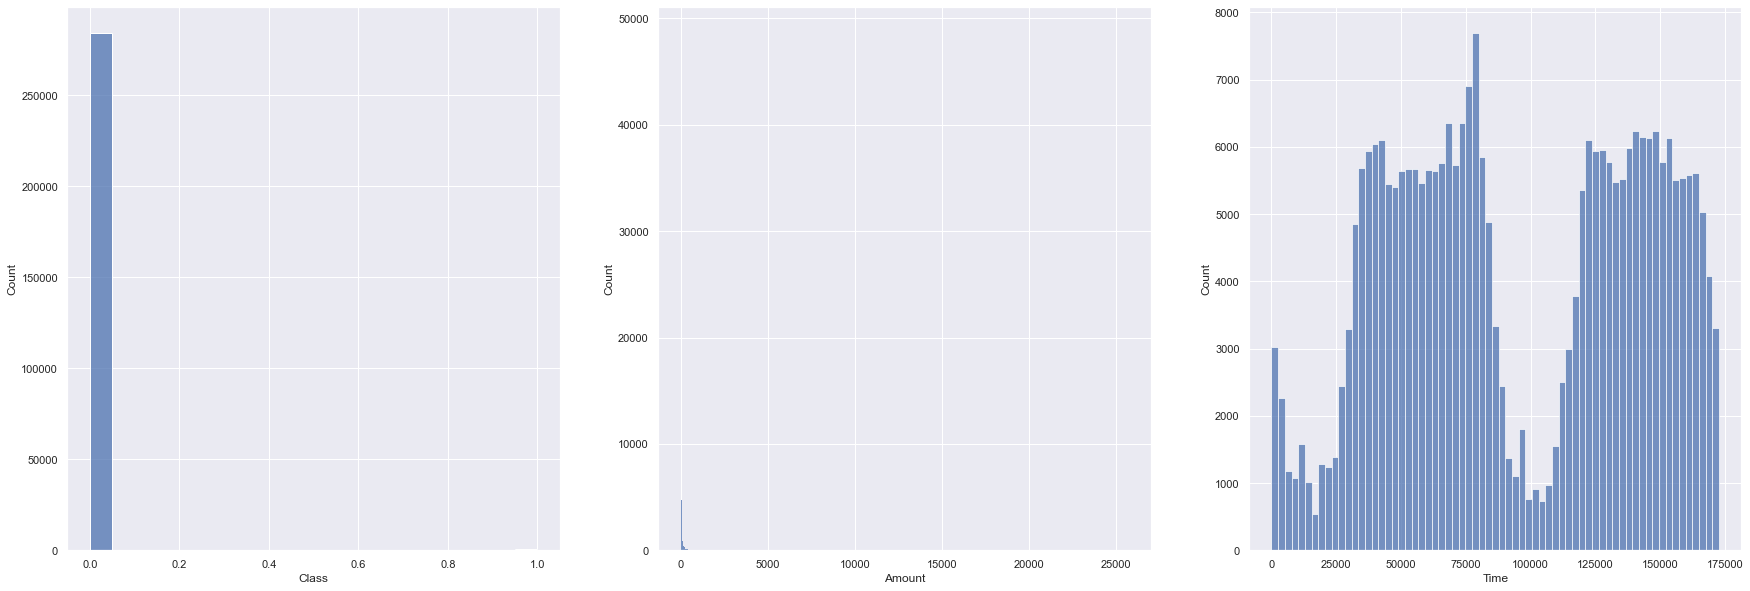

In [13]:
print('Not Frauds', credit_data['Class'].value_counts()[0])
print('Frauds', credit_data['Class'].value_counts()[1])
print('%',round(credit_data['Class'].value_counts()[1]/credit_data['Class'].value_counts()[0] * 100, 2), 'fraud')
analyze_data(credit_data, ['Class', 'Amount', 'Time'])

### Preprocessing
Issues to address:

1. Not all features are scalled
2. Massive imbalance of classes
  - Methods to explore:
    - Resampling
    - Class weighting

In [14]:
def remove_credit_outliers(data):
  ret_data = data
  for column in ret_data.columns[:-1]:
    print(column)

    print('\tBefore removal:', len(ret_data))
    not_fraud = ret_data[column].loc[ret_data['Class'] == 0].values

    q25, q75 = np.percentile(not_fraud, 25), np.percentile(not_fraud, 75)
    iqr = q75 - q25

    cut_off = iqr * 2
    lower, upper = q25 - cut_off, q75 + cut_off

    outliers = [x for x in not_fraud if x < lower or x > upper]


    ret_data =  ret_data.drop(ret_data[(ret_data['Class'] == 0) & ((ret_data[column] > upper) | (ret_data[column] < lower))].index)
    print('\tAfter removal: {}'.format(len(ret_data)))
    print('\tRemoved:', len(outliers))

  return ret_data

Time
	Before removal: 284807
	After removal: 284807
	Removed: 0
V1
	Before removal: 284807
	After removal: 280498
	Removed: 4309
V2
	Before removal: 280498
	After removal: 274942
	Removed: 5556
V3
	Before removal: 274942
	After removal: 274690
	Removed: 252
V4
	Before removal: 274690
	After removal: 270376
	Removed: 4314
V5
	Before removal: 270376
	After removal: 266994
	Removed: 3382
V6
	Before removal: 266994
	After removal: 251485
	Removed: 15509
V7
	Before removal: 251485
	After removal: 249907
	Removed: 1578
V8
	Before removal: 249907
	After removal: 237759
	Removed: 12148
V9
	Before removal: 237759
	After removal: 236577
	Removed: 1182
V10
	Before removal: 236577
	After removal: 234815
	Removed: 1762
V11
	Before removal: 234815
	After removal: 234813
	Removed: 2
V12
	Before removal: 234813
	After removal: 228884
	Removed: 5929
V13
	Before removal: 228884
	After removal: 228756
	Removed: 128
V14
	Before removal: 228756
	After removal: 224568
	Removed: 4188
V15
	Before removal: 224

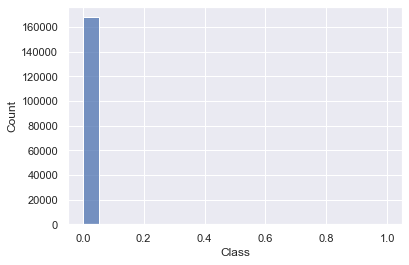

In [15]:
credit_data = scale(credit_data,['Amount', 'Time'])
cleaned_data = remove_credit_outliers(credit_data)
X_train, X_test, y_train, y_test = split_data(cleaned_data)
print(cleaned_data['Class'].value_counts()/len(cleaned_data))
hist(cleaned_data, ['Class'])

Class
1    0.5
0    0.5
Name: count, dtype: float64


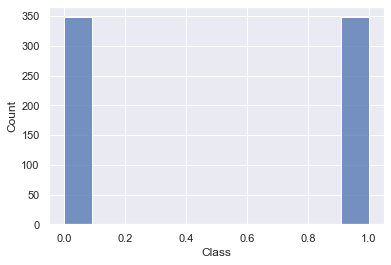

In [16]:
under_sampled_data = under_sample(X_train, y_train)
print(under_sampled_data['Class'].value_counts()/len(under_sampled_data))
hist(under_sampled_data, ['Class'])

Class
1    0.5
0    0.5
Name: count, dtype: float64


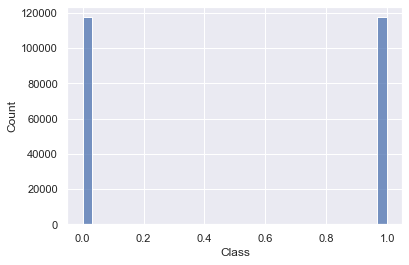

In [17]:
over_sampled_data = over_sample(X_train, y_train)
print(over_sampled_data['Class'].value_counts()/len(over_sampled_data))
hist(over_sampled_data, ['Class'])

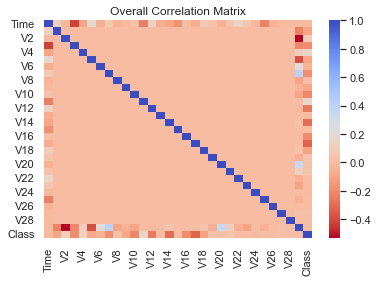

In [18]:
cor_heat(credit_data, 'Overall Correlation Matrix')

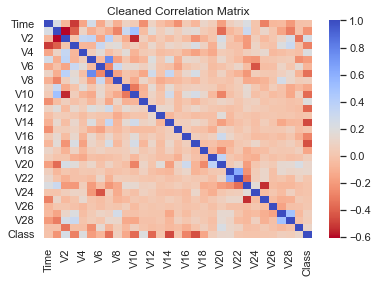

In [19]:
cor_heat(cleaned_data, 'Cleaned Correlation Matrix')


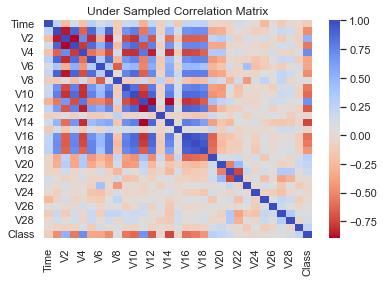

In [20]:
cor_heat(under_sampled_data, 'Under Sampled Correlation Matrix')


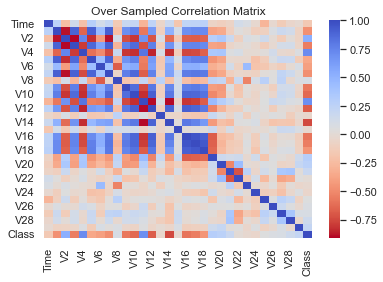

In [21]:
cor_heat(over_sampled_data, 'Over Sampled Correlation Matrix')


### Train
#### Baselines

Establish some baselines with the raw data and cleaned data. These first two confusion matrixs represent models that dont employ any methods to address the imbalances.

              precision    recall  f1-score   support

   not-fraud       1.00      1.00      1.00     85304
       fraud       0.87      0.65      0.74       139

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



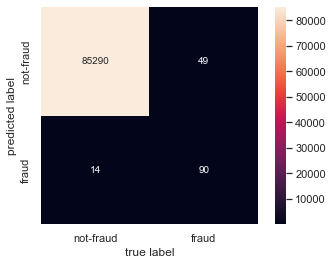

In [22]:
X_train, X_test, y_train, y_test = split_data(credit_data)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

              precision    recall  f1-score   support

   not-fraud       1.00      1.00      1.00     50391
       fraud       0.99      0.94      0.96       144

    accuracy                           1.00     50535
   macro avg       1.00      0.97      0.98     50535
weighted avg       1.00      1.00      1.00     50535



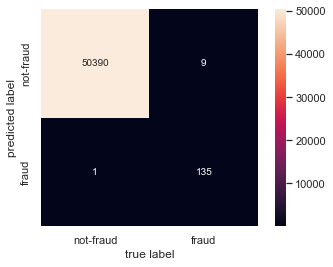

In [23]:
X_train, X_test, y_train, y_test = split_data(cleaned_data)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

#### Over and Under Sampling

              precision    recall  f1-score   support

   not-fraud       1.00      0.99      0.99     50391
       fraud       0.20      0.97      0.33       144

    accuracy                           0.99     50535
   macro avg       0.60      0.98      0.66     50535
weighted avg       1.00      0.99      0.99     50535



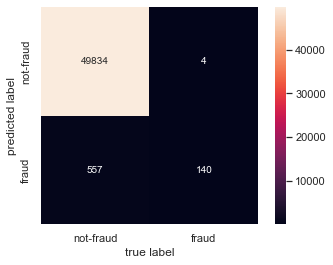

In [24]:
classifier = LogisticRegression()
classifier.fit(under_sampled_data.iloc[:,:-1], under_sampled_data['Class'])

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

              precision    recall  f1-score   support

   not-fraud       1.00      0.98      0.99     50391
       fraud       0.14      0.98      0.25       144

    accuracy                           0.98     50535
   macro avg       0.57      0.98      0.62     50535
weighted avg       1.00      0.98      0.99     50535



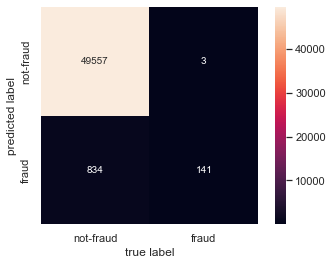

In [25]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(over_sampled_data.iloc[:,:-1], over_sampled_data['Class'])

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

#### Built in function weightage

              precision    recall  f1-score   support

   not-fraud       1.00      0.97      0.99     85304
       fraud       0.05      0.94      0.10       139

    accuracy                           0.97     85443
   macro avg       0.53      0.96      0.55     85443
weighted avg       1.00      0.97      0.99     85443



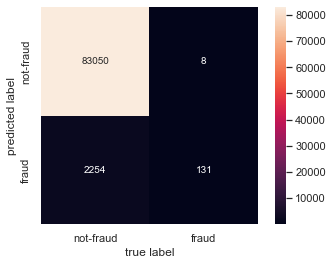

In [26]:
X_train, X_test, y_train, y_test = split_data(credit_data)
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

              precision    recall  f1-score   support

   not-fraud       1.00      0.99      0.99     50391
       fraud       0.17      0.97      0.30       144

    accuracy                           0.99     50535
   macro avg       0.59      0.98      0.64     50535
weighted avg       1.00      0.99      0.99     50535



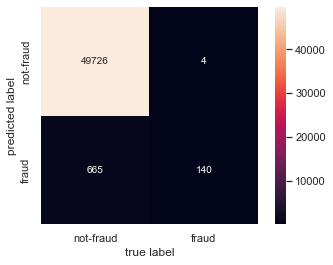

In [27]:
X_train, X_test, y_train, y_test = split_data(cleaned_data)
classifier = LogisticRegression(class_weight='balanced', max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm, cr = evaluate_model(y_test, y_pred, ['not-fraud','fraud'])

### Observations
In the baselines it it clear why accuracy is not a good metric to evaluate such an imbalanced dataset. There also seems to be some overfitting with the cleaned data. However, once the imbalances were addressed the results of the models was much better. Due to the nature of the problem statement I would recommend using one with a high recall value. We would want the model to pick out as many true positives as it can. False positives are not an issue with this data.

## Part B
Problem Statement: Use the following insurance dataset and build a predictive system to predict insurance costs. Demonstrate the steps of data preprocessing and analysis, consider applying train (0.7) and test (0.3), using linear regression to build the model, and evaluate the accuracy of predicting the insurance cost. https://www.kaggle.com/datasets/mirichoi0218/insurance

### Analysis
The standard deviation seems to be fine. I will skip scaling for now

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Nulls:  0


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


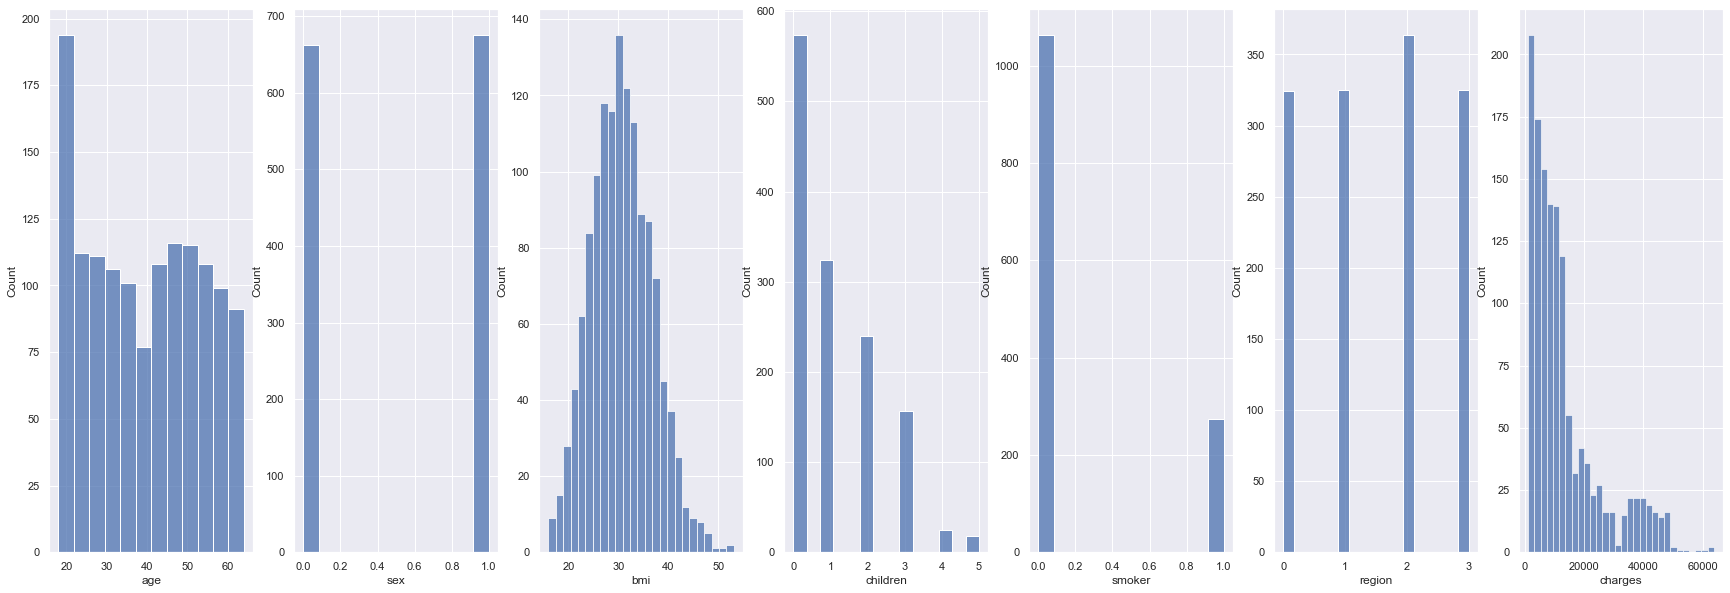

In [28]:
insurance_data = get_data(part_B_data)

display(insurance_data.head())

label_encoder = LabelEncoder()

label_encoder.fit(insurance_data.sex.drop_duplicates()) 
insurance_data.sex = label_encoder.transform(insurance_data.sex)

label_encoder.fit(insurance_data.smoker.drop_duplicates()) 
insurance_data.smoker = label_encoder.transform(insurance_data.smoker)

label_encoder.fit(insurance_data.region.drop_duplicates()) 
insurance_data.region = label_encoder.transform(insurance_data.region)

display(insurance_data.head())

analyze_data(insurance_data, ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

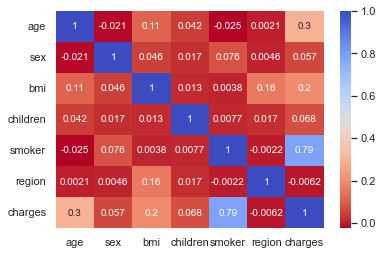

In [29]:

cor_heat(insurance_data, '', True)

Charges seems to have a higher correlation with smoker, age, and bmi.

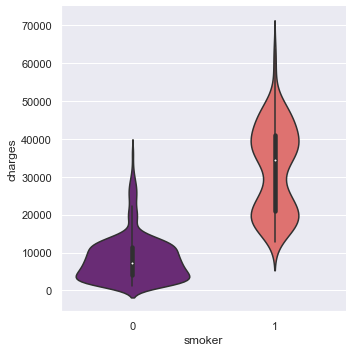

In [30]:
sns.catplot(x="smoker", y="charges", kind="violin", data=insurance_data, palette = 'magma')

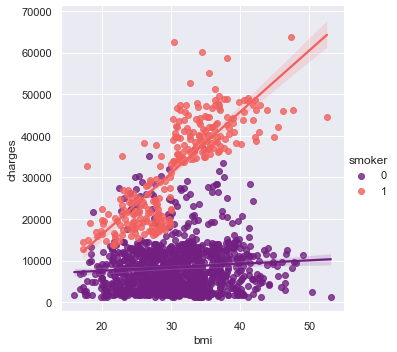

In [31]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=insurance_data, palette = 'magma')

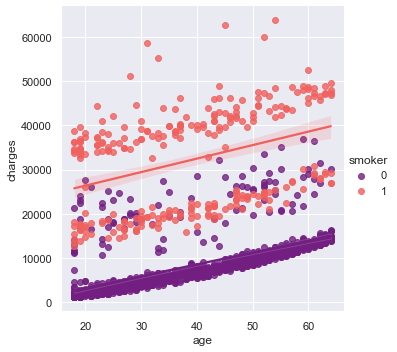

In [36]:
sns.lmplot(x="age", y="charges", hue="smoker", data=insurance_data, palette = 'magma')


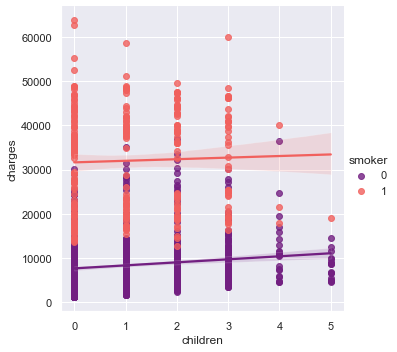

In [33]:
sns.lmplot(x="children", y="charges", hue="smoker", data=insurance_data, palette = 'magma')

<Axes: xlabel='children', ylabel='count'>

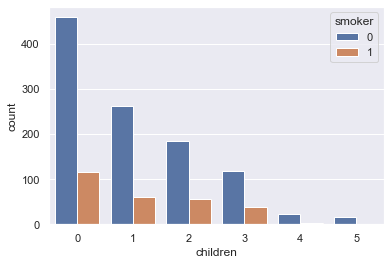

In [34]:
sns.countplot(data=insurance_data, x="children", hue='smoker')

<Axes: xlabel='region', ylabel='charges'>

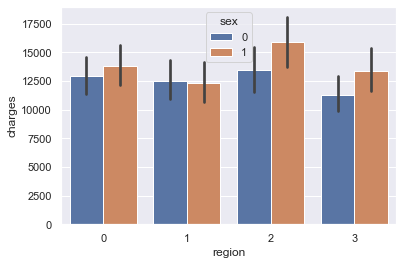

In [35]:
sns.barplot(data=insurance_data, x="region", y='charges', hue='sex')


In [43]:
def remove_insurance_outliers(data):
  ret_data = data.copy()
  for column in ret_data.columns[:-1]:
    print(column)

    print('\tBefore removal:', len(ret_data))
    q25, q75 = np.percentile(ret_data, 25), np.percentile(ret_data, 75)
    iqr = q75 - q25

    cut_off = iqr * 1
    lower, upper = q25 - cut_off, q75 + cut_off

    ret_data =  ret_data.drop(ret_data[(ret_data[column] > upper) | (ret_data[column] < lower)].index)
    print('\tAfter removal: {}'.format(len(ret_data)))
  return ret_data

There seems to be no outliers

In [44]:
cleaned_insurance_data = remove_insurance_outliers(insurance_data)

age
	Before removal: 1338
	After removal: 1338
sex
	Before removal: 1338
	After removal: 1338
bmi
	Before removal: 1338
	After removal: 1338
children
	Before removal: 1338
	After removal: 1338
smoker
	Before removal: 1338
	After removal: 1338
region
	Before removal: 1338
	After removal: 1338


In [40]:
X_train, X_test, y_train, y_test = split_data(insurance_data)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print(regressor.score(X_test,y_test))


0.7416889005412888


In [41]:
scaled_insurance_data = scale(insurance_data, insurance_data.columns)

In [42]:
X_train, X_test, y_train, y_test = split_data(scaled_insurance_data)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print(regressor.score(X_test,y_test))


0.7416889005412888


There is no change to scaling the data